# Diffusion Models on MNIST: A Comprehensive Tutorial

Diffusion tutorial light enough to run on CPU. 
This tutorial demonstrates the whole pipeline, from how to download trained diffusion models from Hugging Face to setting up different integrators for generation and for solving inverse problems.

1. **Loading Models from Hugging Face** - Download and setup pretrained weights
2. **Unconditional Generation** - Generate MNIST digits from noise using different integrators availables in Diffuse: `EulerMaruyamaIntegrator` (stochastic first-order), `DDIMIntegrator` (deterministic first-order), `HeunIntegrator` (deterministic second-order), `DPMpp2sIntegrator` (optimized second-order). 
3. **Conditional Generation** - Solve inverse problems (inpainting) using DPS (Diffusion Posterior Sampling)

## Foreword on Diffuse

Diffusion models learn to reverse a noise corruption process. The `FlowModel` class uses **rectified flow** {cite}`Liu2022` (a.k.a. flow matching) implementing the linear interpolation path

$$
x_t = (1 - t) x_0 + t \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, I), \quad t \in [0, 1]
$$

The learned velocity field will get loaded to the `Predictor`  class and can be evaluated with `predictor.velocity(x, t)`.

While we learn a velocity field, we can use the equivalances developed in the [Diffusion Crash Course](diffusion_crash_course.rst) to convert the velocity field to a score function $s_\theta(x_t, t)$ or to a noise prediction model $\epsilon_\theta(x_t, t)$. This is done automatically in the `Predictor` classes and allows us to sample using integrators originally designed for score-based or noise prediction models, eg the `DDIMIntegrator`.

Building on top of the `Integrator` base class, `CondDenoiser` classes implement different conditional sampling strategies for solving inverse problems. In this tutorial, we will use the `DPSDenoiser` class implementing Diffusion Posterior Sampling (DPS) {cite}`Chung2022`. Even if originally designed for score-based models and `DDIMIntegrator` or `EulerMaruyamaIntegrator`, the `DPSDenoiser` class can be used with any integrator available in Diffuse and any interpolating path (eg rectified flow).


## Setup and Model Loading

First, we'll set up the environment and download a pretrained model from Hugging Face.

In [112]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Diffuse library imports
from diffuse.diffusion.sde import Flow
from diffuse.denoisers.denoiser import Denoiser
from diffuse.denoisers.cond import DPSDenoiser
from diffuse.integrator.deterministic import DDIMIntegrator, HeunIntegrator, DPMpp2sIntegrator
from diffuse.integrator.stochastic import EulerMaruyamaIntegrator
from diffuse.timer import VpTimer
from diffuse.predictor import Predictor
from diffuse.base_forward_model import MeasurementState
from diffuse.examples.mnist.forward_model import SquareMask

### Download Model from Hugging Face

We'll download the pretrained MNIST model from Hugging Face Hub. This model was trained using rectified flow and flow matching loss.

In [113]:
from huggingface_hub import hf_hub_download
from flax import nnx, serialization
import importlib.util

# Download model weights and config from Hugging Face
REPO_ID = "jcopo/mnist"  # Replace with your repo if different

print("Downloading model from HuggingFace Hub...")
model_path = hf_hub_download(repo_id=REPO_ID, filename="model.msgpack")
config_path = hf_hub_download(repo_id=REPO_ID, filename="config.py")

# Load config to get model architecture
spec = importlib.util.spec_from_file_location("model_config", config_path)
config_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_module)

# Initialize model from config
model = config_module.model

# Load weights
with open(model_path, "rb") as f:
    state_dict = serialization.from_bytes(None, f.read())

# Restore weights into model
graphdef, state = nnx.split(model)
state.replace_by_pure_dict(state_dict)
model = nnx.merge(graphdef, state)
model.eval()  # Set to evaluation mode

print(f"Model loaded successfully ({type(model).__name__})")

Model loaded successfully (CondUNet2D)


### Setup Flow Model and Predictor

We use a **Flow** (rectified flow) model with **velocity prediction**. The predictor converts between different parameterizations (score, noise, velocity, x0), allowing us to use any integrator regardless of its original formulation.

In [114]:
# Create Flow model (rectified flow)
flow = Flow()


# Create network wrapper
def network_fn(x, t):
    """Neural network velocity field v_θ(x,t)"""
    return model(x, t).output


# Create predictor with velocity prediction type
predictor = Predictor(model=flow, network=network_fn, prediction_type="velocity")

# Test model inference
key = jax.random.PRNGKey(42)
batch_size = 4
img_shape = (28, 28, 1)

# Create dummy input
dummy_x = jax.random.normal(key, (batch_size, *img_shape))
dummy_t = jnp.ones((batch_size,)) * 0.5

# Run model forward pass
output = model(dummy_x, dummy_t)
velocity = predictor.velocity(dummy_x[0], dummy_t[0])
score = predictor.score(dummy_x[0], dummy_t[0])

## Unconditional Generation: Comparing Integrators
We now will generate MNIST digits from pure noise using several numerical integrators, each solving the diffusion dynamics in a distinct way.

**Euler–Maruyama**: `EulerMaruyamaIntegrator`   
A stochastic integrator that discretizes the reverse-time SDE, adding Gaussian noise at each step. It promotes diverse generations but may yield slightly blurrier samples.

**DDIM**: `DDIMIntegrator`  
A deterministic reformulation of the diffusion sampling process {cite}`Song2020b`, removing stochasticity to produce consistent, high-quality samples with fewer denoising steps.

**Heun**: `HeunIntegrator`  
A second-order Runge–Kutta (predictor–corrector) solver for the probability flow ODE, offering improved local accuracy and stability compared to first-order methods.

**DPM++**: `DPMpp2sIntegrator`  
A family of multi-step solvers {cite}`Lu2022` that use adaptive step updates and midpoint prediction for fast, high-fidelity sampling, representing the current state of the art among diffusion ODE integrators.

We will compare the generations obtained from these integrators side by side.


In [115]:
# Setup common parameters
n_steps = 50
n_samples = 16

# VpTimer: Creates equidistant time discretization between 0 and 1 with n_steps
# eps is used to clip time for numerical stability near 0
timer = VpTimer(eps=1e-3, tf=1.0, n_steps=n_steps)

# Euler-Maruyama: Stochastic integrator
euler_maruyama = EulerMaruyamaIntegrator(model=flow, timer=timer)

# DDIM: Deterministic integrator
ddim = DDIMIntegrator(model=flow, timer=timer)

# Heun: Second-order deterministic integrator
heun = HeunIntegrator(model=flow, timer=timer)

# DPM++: Multi-step second-order deterministic integrator
dpmpp = DPMpp2sIntegrator(model=flow, timer=timer)

All integrators can be used interchangeably by simply changing the `integrator` argument in the `Denoiser` class. To generate samples, we simply call the `generate` method with a random key, number of steps, and number of samples. `keep_history=True` allows us to store intermediate states for visualization.

In [116]:
euler_denoiser = Denoiser(
    integrator=euler_maruyama,
    model=flow,  # The SDE/Flow model
    predictor=predictor,
    x0_shape=img_shape,
)
key_euler = jax.random.PRNGKey(456)
state_euler, history_euler = euler_denoiser.generate(key_euler, n_steps, n_samples, keep_history=True)

We've generated samples with Euler-Maruyama. Now let's generate with the other integrators (`DDIMIntegrator`, `HeunIntegrator`, `DPMpp2sIntegrator`) and compare the results.

In [117]:
results = {}
results["Euler-Maruyama"] = {"samples": state_euler.integrator_state.position, "history": history_euler}
# Generate with remaining integrators (same pattern as above)

# DDIM
ddim_denoiser = Denoiser(integrator=ddim, model=flow, predictor=predictor, x0_shape=img_shape)
key_ddim = jax.random.PRNGKey(457)
state_ddim, history_ddim = ddim_denoiser.generate(key_ddim, n_steps, n_samples, keep_history=True)
results["DDIM"] = {"samples": state_ddim.integrator_state.position, "history": history_ddim}

# Heun
heun_denoiser = Denoiser(integrator=heun, model=flow, predictor=predictor, x0_shape=img_shape)
key_heun = jax.random.PRNGKey(458)
state_heun, history_heun = heun_denoiser.generate(key_heun, n_steps, n_samples, keep_history=True)
results["Heun"] = {"samples": state_heun.integrator_state.position, "history": history_heun}

# DPM++
dpmpp_denoiser = Denoiser(integrator=dpmpp, model=flow, predictor=predictor, x0_shape=img_shape)
key_dpmpp = jax.random.PRNGKey(459)
state_dpmpp, history_dpmpp = dpmpp_denoiser.generate(key_dpmpp, n_steps, n_samples, keep_history=True)
results["DPM++"] = {"samples": state_dpmpp.integrator_state.position, "history": history_dpmpp}

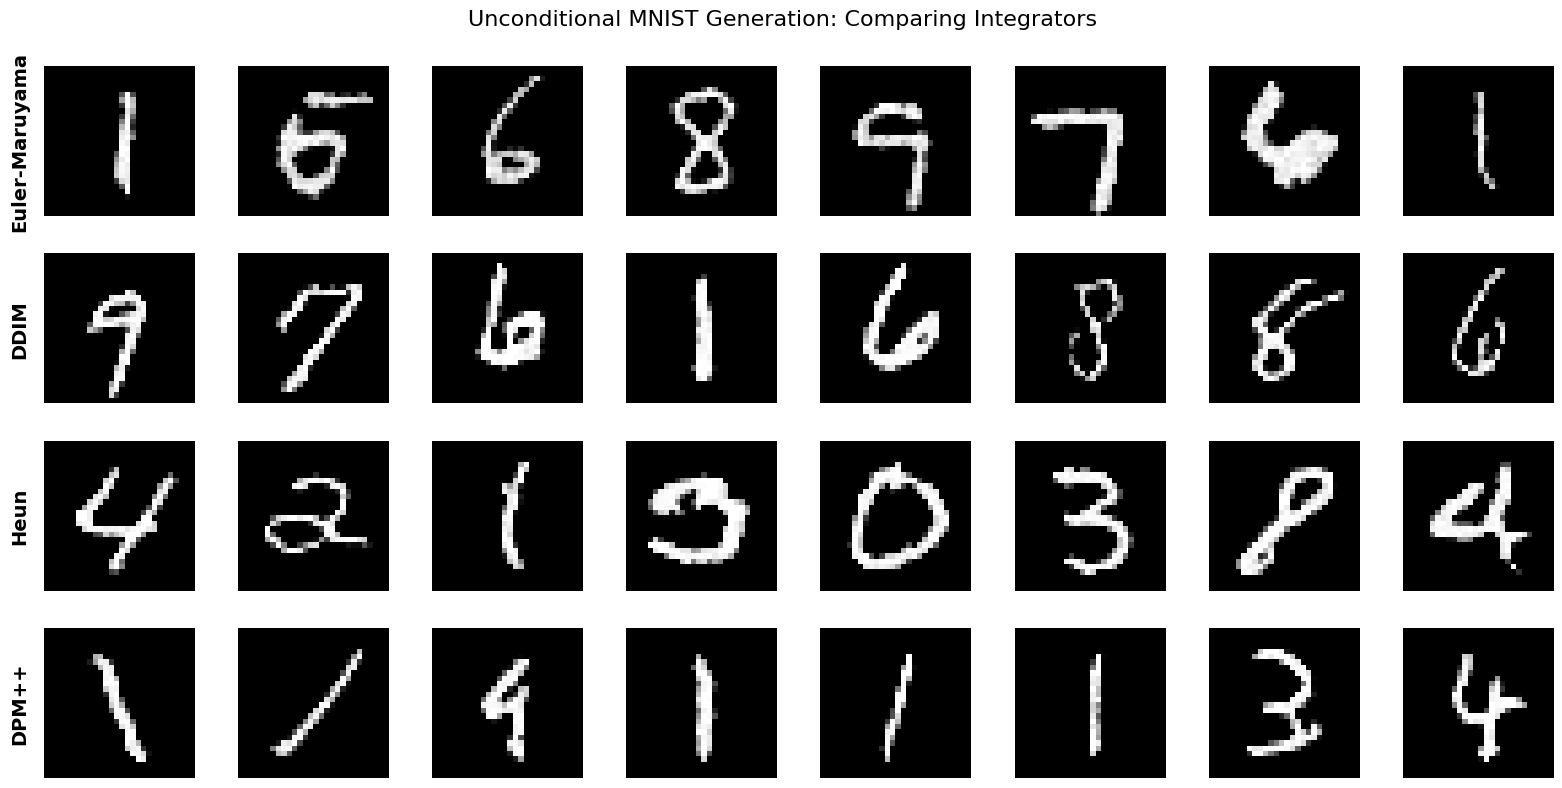

In [118]:
# Visualize samples from all integrators
integrator_names = ["Euler-Maruyama", "DDIM", "Heun", "DPM++"]

fig, axes = plt.subplots(len(integrator_names), 8, figsize=(16, 2 * len(integrator_names)))
fig.suptitle("Unconditional MNIST Generation: Comparing Integrators", fontsize=16, y=0.98)

for row, name in enumerate(integrator_names):
    samples = jnp.clip(results[name]["samples"], 0, 1)  # Clip to [0,1] for display
    for col in range(8):
        axes[row, col].imshow(samples[col].squeeze(), cmap="gray", vmin=0, vmax=1)
        axes[row, col].axis("off")

    # Add method name on the left (vertical)
    axes[row, 0].text(
        -0.1,
        0.5,
        name,
        transform=axes[row, 0].transAxes,
        fontsize=14,
        fontweight="bold",
        verticalalignment="center",
        horizontalalignment="right",
        rotation=90,
    )

plt.tight_layout()
plt.show()

### What to Look For: Unconditional Generation
- **Euler-Maruyama**: May show more variation between samples (stochastic)
- **DDIM**: Should produce clean, sharp digits
- **Heun/DPM++**: Often highest quality, smoothest gradients

As we used the arguments `keep_history=True` we can visualize the entire sampling trajectory:

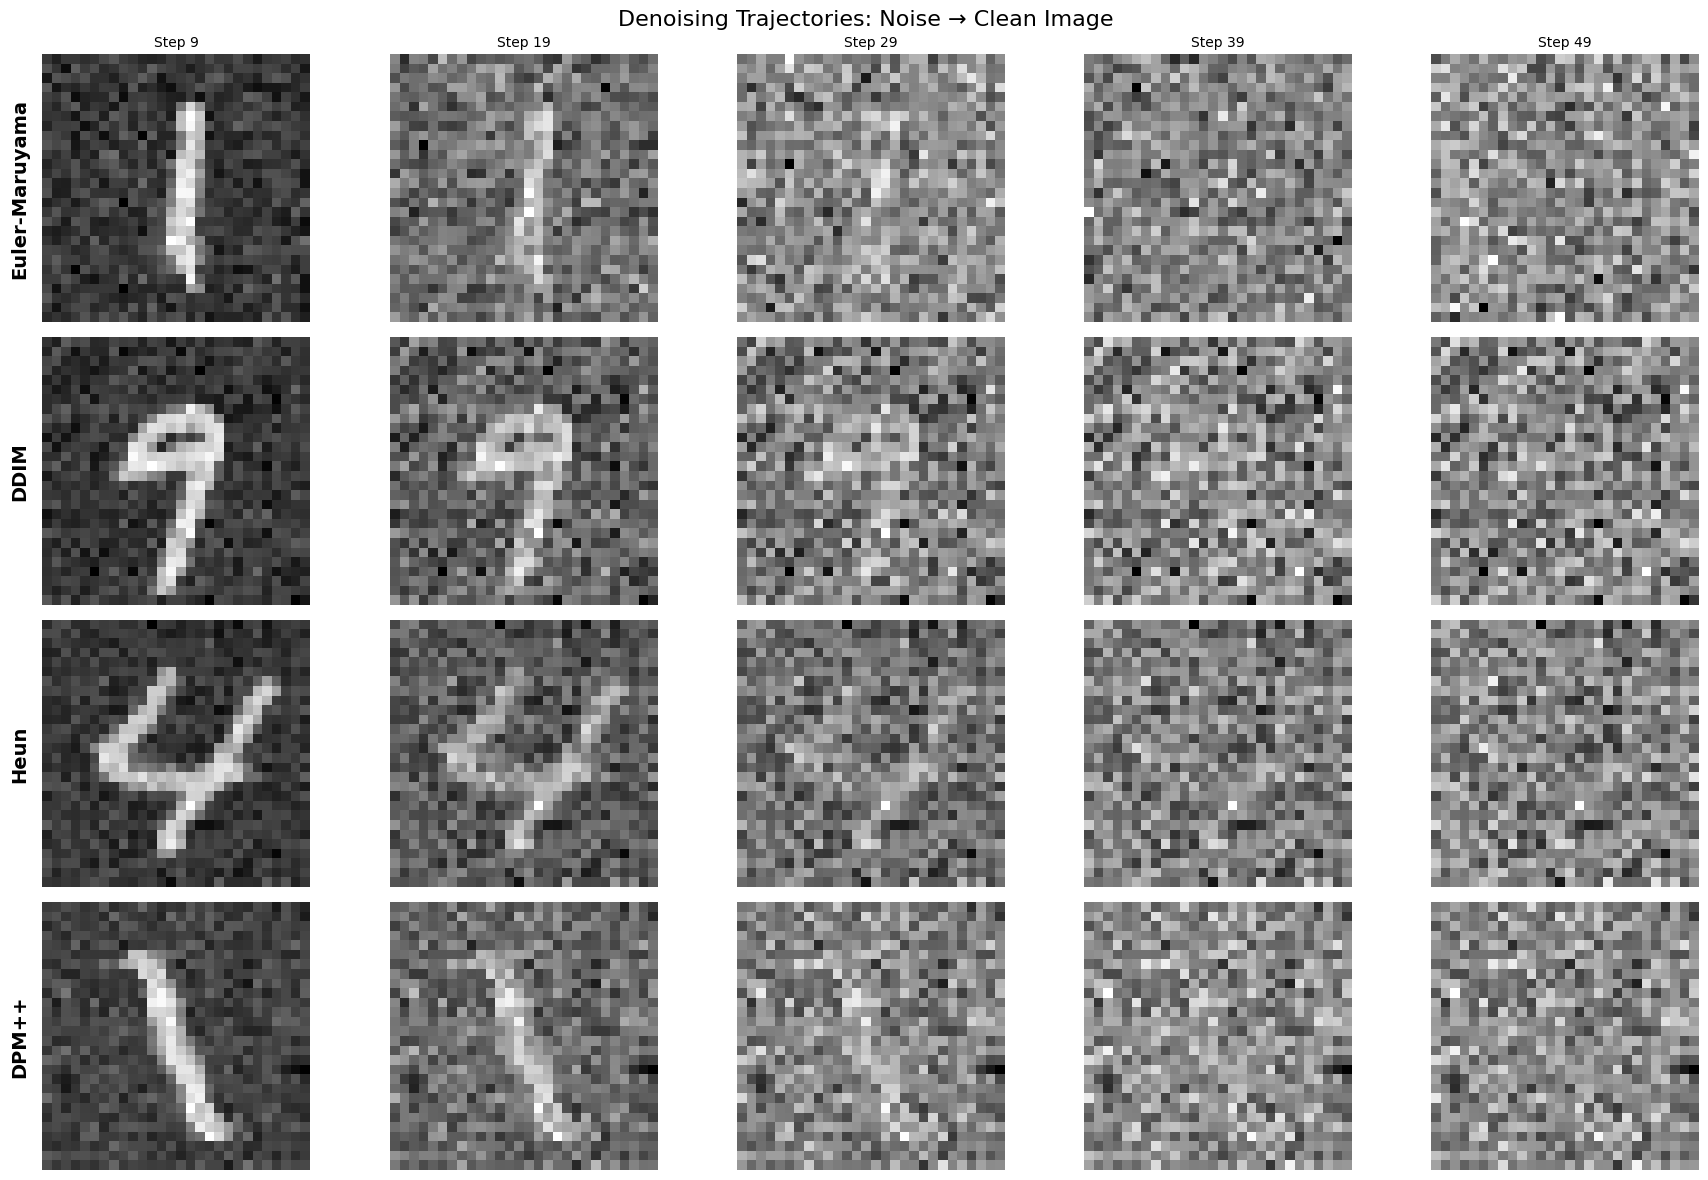

In [119]:
# Visualize denoising trajectories
n_timesteps = 5
timestep_indices = jnp.linspace(9, n_steps - 1, n_timesteps, dtype=int)
sample_idx = 0

integrator_names = ["Euler-Maruyama", "DDIM", "Heun", "DPM++"]

fig, axes = plt.subplots(len(integrator_names), n_timesteps, figsize=(18, 3 * len(integrator_names)))
fig.suptitle("Denoising Trajectories: Noise → Clean Image", fontsize=16, y=0.98)

for row, name in enumerate(integrator_names):
    history = results[name]["history"][::-1]  # Reverse to show noise→clean
    for col, t_idx in enumerate(timestep_indices):
        img = history[t_idx, sample_idx].squeeze()
        # Normalize each timestep to [0,1] for better visualization
        img_normalized = (img - img.min()) / (img.max() - img.min() + 1e-8)
        axes[row, col].imshow(img_normalized, cmap="gray", vmin=0, vmax=1)
        axes[row, col].axis("off")

        if row == 0:
            axes[row, col].set_title(f"Step {t_idx}", fontsize=10)

    axes[row, 0].text(
        -0.05,
        0.5,
        name,
        transform=axes[row, 0].transAxes,
        fontsize=14,
        fontweight="bold",
        verticalalignment="center",
        horizontalalignment="right",
        rotation=90,
    )

plt.tight_layout()
plt.show()

---

Now that we've seen unconditional generation, let's tackle a more challenging task: **solving inverse problems** where we have partial observations and want to reconstruct the full image.

## Conditional Generation: Solving Inverse Problems

Conditional generation solves **inverse problems** where we want to generate $x_0 \sim p(x_0|y)$ given measurements $y = \mathcal{A}(x_0) + \epsilon$.

### Example: Image Inpainting

We'll reconstruct masked MNIST digits using **DPS (Diffusion Posterior Sampling)** {cite}`Chung2022`.

Think of DPS as a "guided" diffusion process:
1. **Regular diffusion step**: Move from noisy → less noisy using the learned model
2. **Measurement correction**: Check if the current estimate matches your observations (y)
3. **Gradient guidance**: Nudge the sample toward solutions that better match measurements

Mathematically:
- Uses gradient of measurement likelihood: $\nabla_x \log p(y|x_t)$
- Updates: $x_{t-1} = \text{step}(x_t, t) - \gamma \nabla_x \|y - \mathcal{A}(x_t)\|^2$ where $\text{step}(x_t, t)$ is the unconditional integrator step

**The zeta parameter** controls how strongly we enforce measurement consistency:
- Too high → overfits to measurements, artifacts
- Too low → ignores measurements, poor reconstruction

This is easily implemented in our framework as everything is modular:

```python
@dataclass
class DPSDenoiser(CondDenoiser):
    epsilon: float = 1e-3  # Small constant to avoid division by zero in norm calculation
    zeta: float = 1e-2
    def step(
        self,
        rng_key: PRNGKeyArray,
        state: CondDenoiserState,
        measurement_state: MeasurementState,
    ) -> CondDenoiserState:
        y_meas = measurement_state.y
        position_current = state.integrator_state.position
        t_current = self.integrator.timer(state.integrator_state.step)

        # Compute measurement loss and gradient at current position
        def measurement_loss(x: Array) -> Array:
            # Tweedie estimate: x̂_0 from x at time t
            denoised = self.model.tweedie(
                                        SDEState(x, t_current), 
                                        self.predictor.score).position
            # Measurement consistency loss: ||y - A(x̂_0)||²
            residual = y_meas - self.forward_model.apply(denoised, measurement_state)
            return jnp.sum(residual ** 2)

        # Compute loss value and gradient ∇_x ||y - A(x̂_0)||²
        loss_val, gradient = jax.value_and_grad(measurement_loss)(position_current)

        # Adaptive guidance scale, normalized by residual magnitude
        zeta = self.zeta / (jnp.sqrt(loss_val) + self.epsilon)

        # Take unconditional integrator step (works with any integrator)
        integrator_state_uncond = self.integrator(state.integrator_state, self.predictor)

        # Apply measurement correction: x_{i-1} = x'_{i-1} - ζ ∇_x ||y - A(x̂_0)||²
        position_corrected = integrator_state_uncond.position - zeta * gradient

        # Create next state with corrected position
        integrator_state_next = replace(integrator_state_uncond, position=position_corrected)
        state_next = replace(state, integrator_state=integrator_state_next)

        return state_next
```




Let's start with a square mask in the center of the image that selects which pixels are observed (1) and which are missing (0):

In [120]:
# Use a generated sample as test image
test_image = jnp.clip(results["DDIM"]["samples"][0], 0, 1)
# Create inpainting measurement
mask_model = SquareMask(size=8, img_shape=test_image.shape, std=0.1)
xi_center = jnp.array([14.0, 14.0])  # Center of 28x28 image
mask = mask_model.make(xi_center)
masked_image = test_image * mask

# Create measurement state
measurement_state = MeasurementState(y=masked_image, mask_history=mask)

print(f"Inpainting task: {jnp.mean(mask):.1%} visible, {jnp.mean(1 - mask):.1%} to reconstruct")

Inpainting task: 8.3% visible, 91.7% to reconstruct


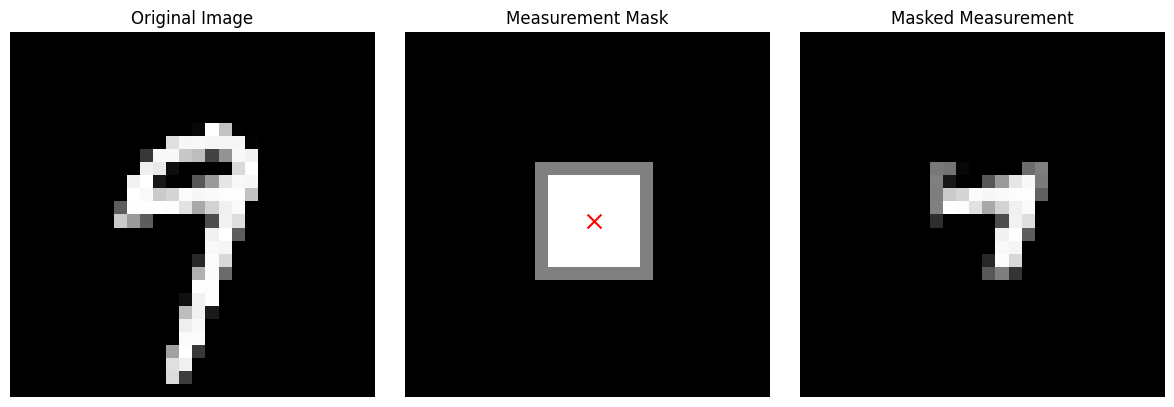

In [121]:
# Visualize measurement
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(test_image.squeeze(), cmap="gray", vmin=0, vmax=1)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(mask.squeeze(), cmap="gray", vmin=0, vmax=1)
axes[1].set_title("Measurement Mask")
axes[1].scatter(xi_center[0], xi_center[1], c="red", s=100, marker="x")
axes[1].axis("off")

axes[2].imshow(masked_image.squeeze(), cmap="gray", vmin=0, vmax=1)
axes[2].set_title("Masked Measurement")
axes[2].axis("off")

plt.tight_layout()
plt.show()

Let's create the `DPSDenoiser`  with the `EulerMaruyamaIntegrator` and the `mask_model` as forward model $\mathcal{A}$:

In [122]:
dps_euler_denoiser = DPSDenoiser(
    integrator=euler_maruyama,
    model=flow,  # The SDE/Flow model
    predictor=predictor,
    forward_model=mask_model,  # The measurement/masking operator
    x0_shape=img_shape,
    zeta=0.5,  # Guidance scale
)

All is needed to generate samples is to call the `generate` method of the `DPSDenoiser` instance with a random key and the number of samples we want.

In [123]:
# Generate conditional samples with DPS + Euler-Maruyama (showing the pattern)
n_cond_samples = 8

key_dps_euler = jax.random.PRNGKey(789)
state_dps_euler, history_dps_euler = dps_euler_denoiser.generate(
    key_dps_euler,
    measurement_state,  # Pass the measurement (masked image)
    n_steps,
    n_cond_samples,
    keep_history=True,
)

Now let's generate samples with DPS using the other integrators (`DDIMIntegrator`, `HeunIntegrator`, `DPMpp2sIntegrator`) and compare both the generated samples and denoising trajectories.

In [124]:
# Create remaining DPS denoisers (same pattern as above)

# DPS with DDIM
dps_ddim_denoiser = DPSDenoiser(
    integrator=ddim,
    model=flow,
    predictor=predictor,
    forward_model=mask_model,
    x0_shape=img_shape,
    zeta=0.5,  # Guidance scale
)

# DPS with Heun
dps_heun_denoiser = DPSDenoiser(
    integrator=heun,
    model=flow,
    predictor=predictor,
    forward_model=mask_model,
    x0_shape=img_shape,
    zeta=0.5,  # Guidance scale
)

# DPS with DPM++
dps_dpmpp_denoiser = DPSDenoiser(
    integrator=dpmpp,
    model=flow,
    predictor=predictor,
    forward_model=mask_model,
    x0_shape=img_shape,
    zeta=0.5,  # Guidance scale
)

# Keep dictionary for visualization code
cond_denoisers = {
    "Euler-Maruyama": dps_euler_denoiser,
    "DDIM": dps_ddim_denoiser,
    "Heun": dps_heun_denoiser,
    "DPM++": dps_dpmpp_denoiser,
}

In [125]:
# Generate with remaining DPS denoisers (same pattern as above)
cond_results = {}
cond_results["Euler-Maruyama"] = {"samples": state_dps_euler.integrator_state.position, "history": history_dps_euler}


# DPS + DDIM
key_dps_ddim = jax.random.PRNGKey(790)
state_dps_ddim, history_dps_ddim = dps_ddim_denoiser.generate(
    key_dps_ddim,
    measurement_state,
    n_steps,
    n_cond_samples,
    keep_history=True,
)
cond_results["DDIM"] = {"samples": state_dps_ddim.integrator_state.position, "history": history_dps_ddim}

# DPS + Heun
key_dps_heun = jax.random.PRNGKey(791)
state_dps_heun, history_dps_heun = dps_heun_denoiser.generate(
    key_dps_heun,
    measurement_state,
    n_steps,
    n_cond_samples,
    keep_history=True,
)
cond_results["Heun"] = {"samples": state_dps_heun.integrator_state.position, "history": history_dps_heun}

# DPS + DPM++
key_dps_dpmpp = jax.random.PRNGKey(792)
state_dps_dpmpp, history_dps_dpmpp = dps_dpmpp_denoiser.generate(
    key_dps_dpmpp,
    measurement_state,
    n_steps,
    n_cond_samples,
    keep_history=True,
)
cond_results["DPM++"] = {"samples": state_dps_dpmpp.integrator_state.position, "history": history_dps_dpmpp}

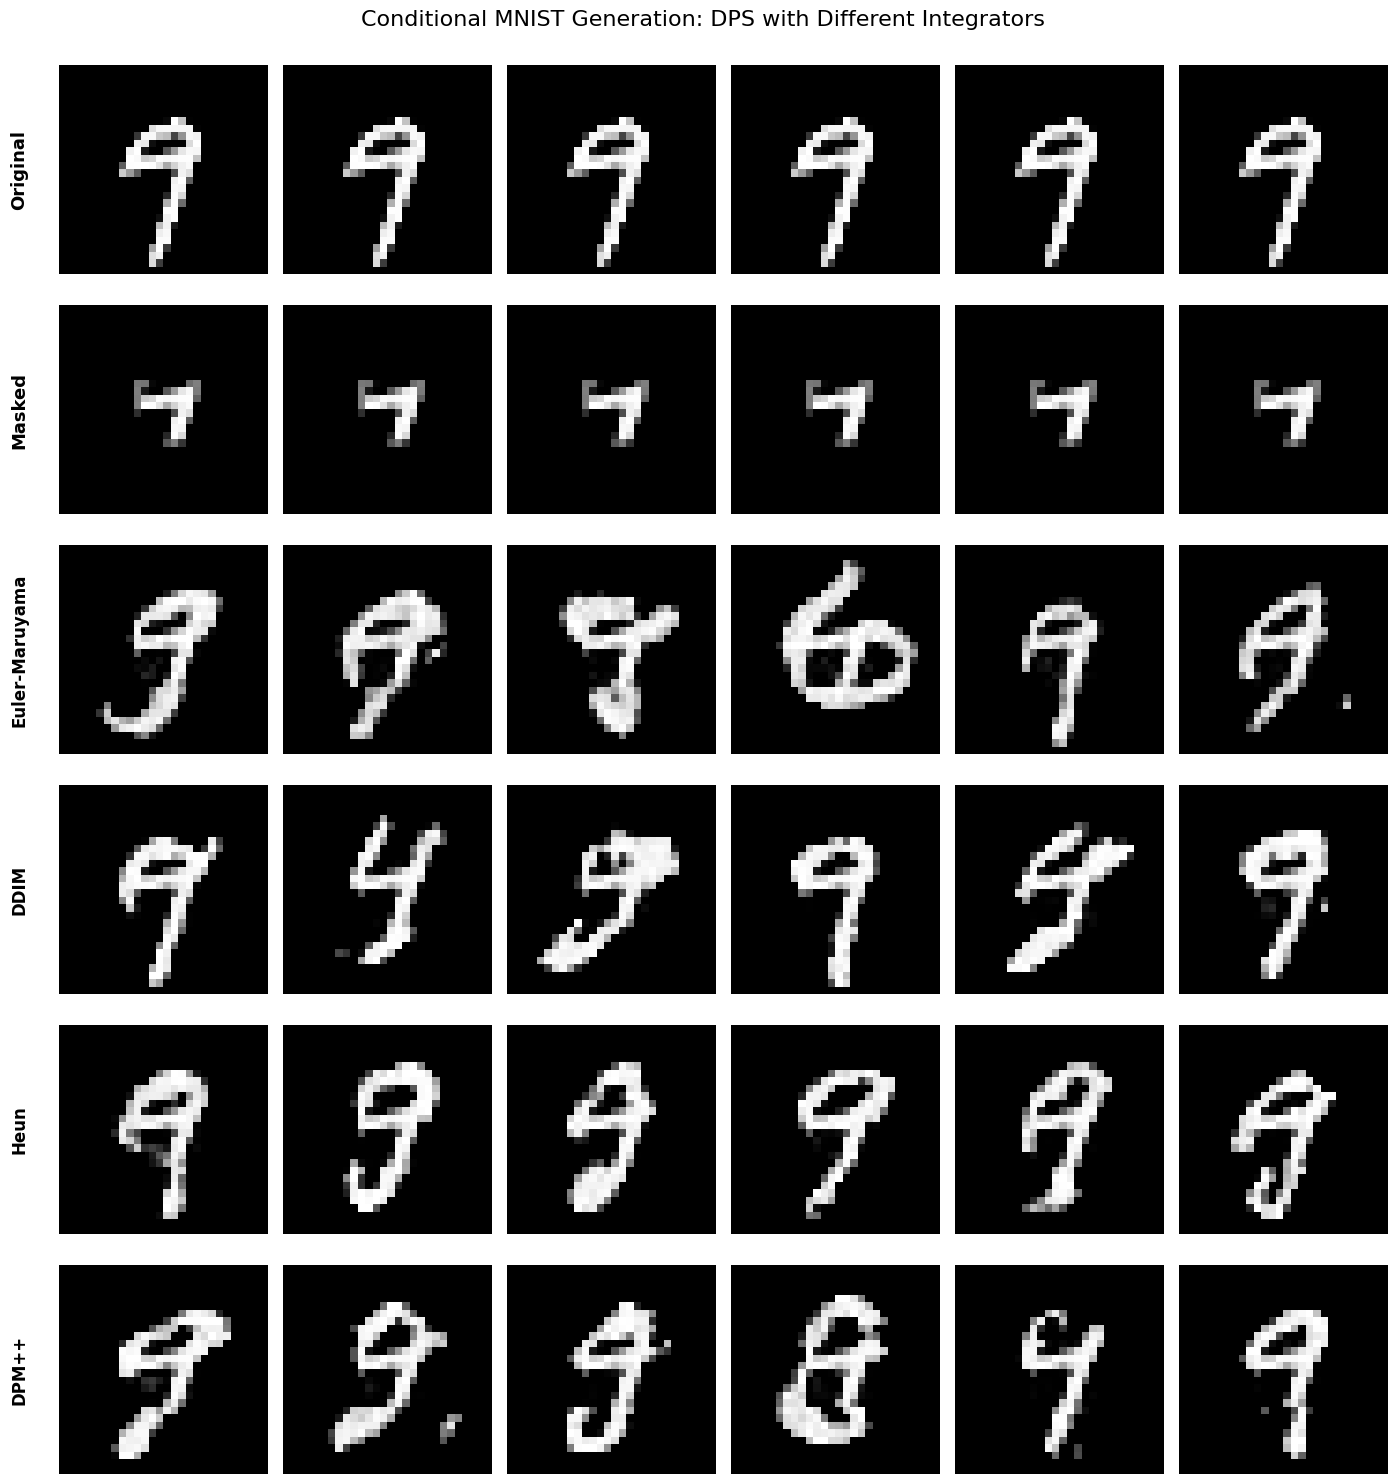

In [126]:
# Visualize conditional generation results: DPS with different integrators
n_samples_to_show = 6

fig, axes = plt.subplots(len(cond_denoisers) + 2, n_samples_to_show, figsize=(14, 2.5 * (len(cond_denoisers) + 2)))
fig.suptitle("Conditional MNIST Generation: DPS with Different Integrators", fontsize=16, y=0.995)

# Row 0: Original image
for col in range(n_samples_to_show):
    axes[0, col].imshow(test_image.squeeze(), cmap="gray", vmin=0, vmax=1)
    axes[0, col].axis("off")

axes[0, 0].text(
    -0.15,
    0.5,
    "Original",
    transform=axes[0, 0].transAxes,
    fontsize=13,
    fontweight="bold",
    verticalalignment="center",
    horizontalalignment="right",
    rotation=90,
)

# Row 1: Masked measurement
for col in range(n_samples_to_show):
    axes[1, col].imshow(masked_image.squeeze(), cmap="gray", vmin=0, vmax=1)
    axes[1, col].axis("off")

axes[1, 0].text(
    -0.15,
    0.5,
    "Masked",
    transform=axes[1, 0].transAxes,
    fontsize=13,
    fontweight="bold",
    verticalalignment="center",
    horizontalalignment="right",
    rotation=90,
)

# Rows 2+: DPS reconstructions with different integrators
for row, (int_name, data) in enumerate(cond_results.items(), start=2):
    samples = jnp.clip(data["samples"], 0, 1)

    for col in range(n_samples_to_show):
        axes[row, col].imshow(samples[col].squeeze(), cmap="gray", vmin=0, vmax=1)
        axes[row, col].axis("off")

    # Add integrator label (vertical)
    axes[row, 0].text(
        -0.15,
        0.5,
        int_name,
        transform=axes[row, 0].transAxes,
        fontsize=12,
        fontweight="bold",
        verticalalignment="center",
        horizontalalignment="right",
        rotation=90,
    )

plt.tight_layout()
plt.show()

### What to Look For: Conditional Generation
- **Euler-Maruyama**: May show more variation between samples (stochastic)
- **DDIM**: Should produce clean, sharp digits
- **Heun/DPM++**: Often highest quality, smoothest gradients

All methods should correctly preserve the central visible regions while plausibly reconstructing the outside of the center square.

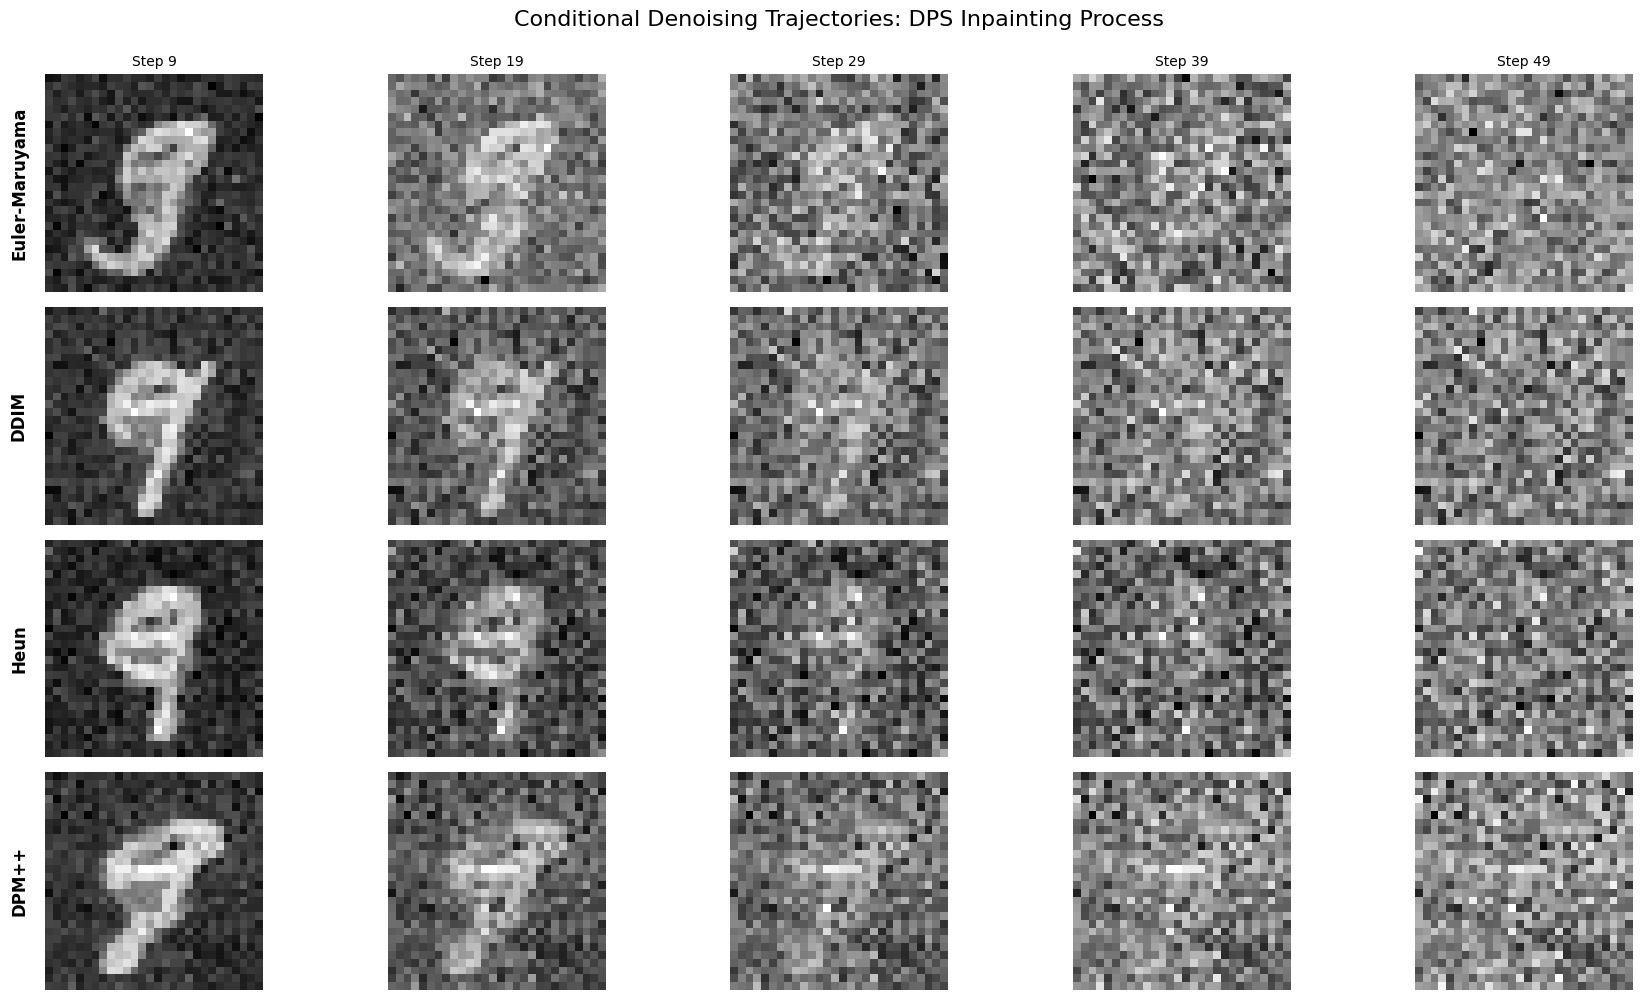

In [127]:
# Visualize conditional denoising trajectories for DPS with each integrator
sample_idx = 0

fig, axes = plt.subplots(len(cond_denoisers), n_timesteps, figsize=(18, 2.5 * len(cond_denoisers)))
fig.suptitle("Conditional Denoising Trajectories: DPS Inpainting Process", fontsize=16, y=0.995)

for row, (int_name, data) in enumerate(cond_results.items()):
    history = data["history"][::-1]  # Reverse to show noise→clean

    for col, t_idx in enumerate(timestep_indices):
        img = history[t_idx, sample_idx].squeeze()
        # Normalize each timestep to [0,1] for better visualization
        img_normalized = (img - img.min()) / (img.max() - img.min() + 1e-8)
        axes[row, col].imshow(img_normalized, cmap="gray", vmin=0, vmax=1)
        axes[row, col].axis("off")

        if row == 0:
            axes[row, col].set_title(f"Step {t_idx}", fontsize=10)

    # Add integrator label (vertical)
    axes[row, 0].text(
        -0.08,
        0.5,
        int_name,
        transform=axes[row, 0].transAxes,
        fontsize=12,
        fontweight="bold",
        verticalalignment="center",
        horizontalalignment="right",
        rotation=90,
    )

plt.tight_layout()
plt.show()

### Verification: Measurement Consistency

Let's verify that the inpainted digits correctly preserve the conditioning measurements by overlaying them in red:

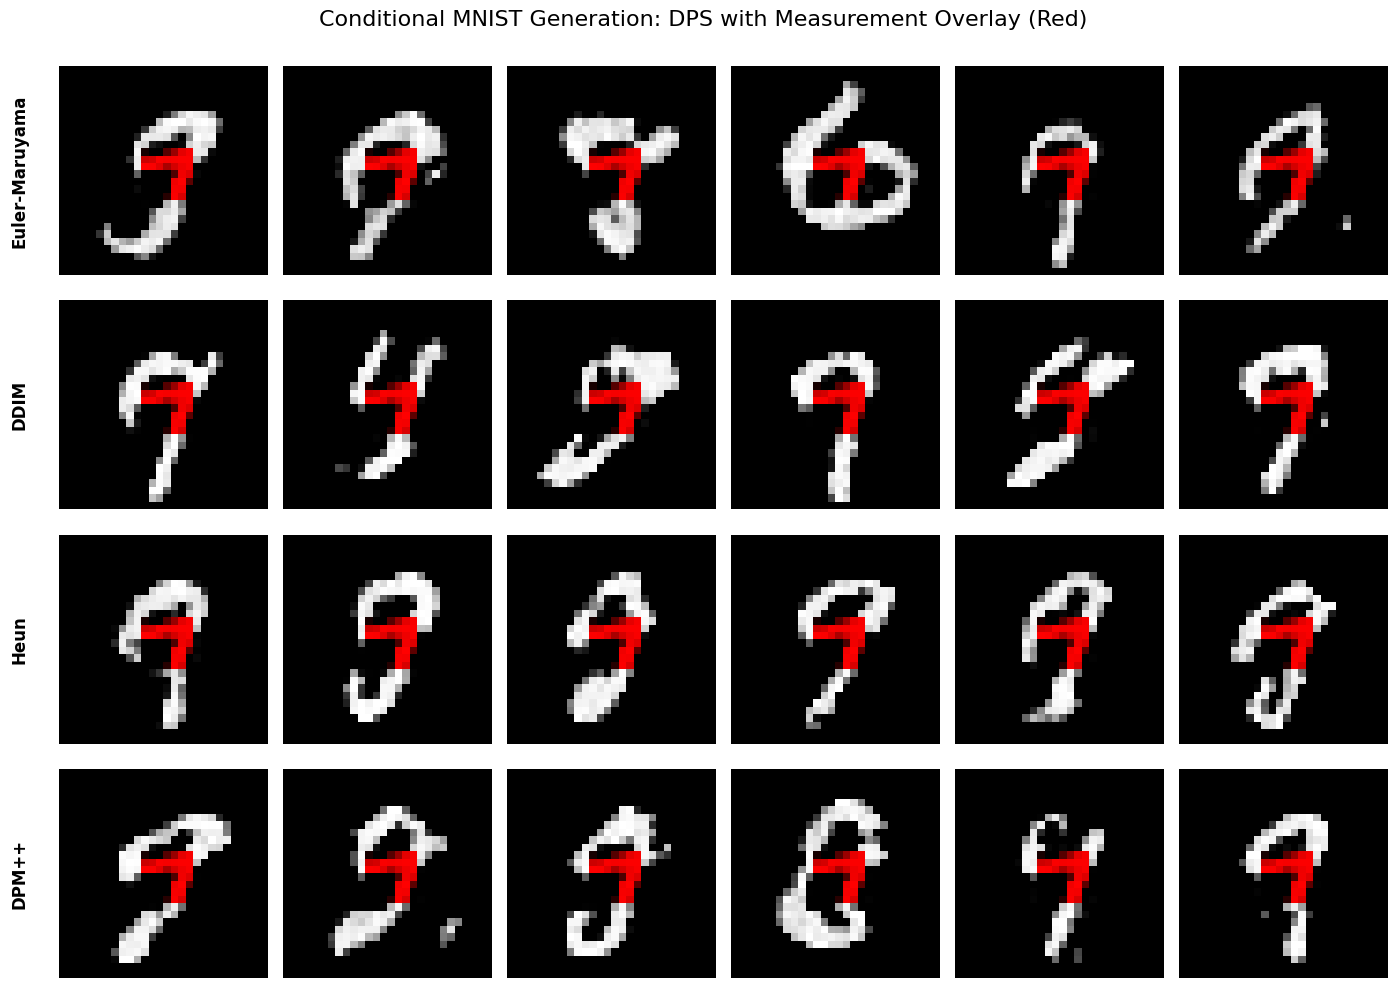

In [128]:
# Visualize conditional generation with measurement overlay in red
n_samples_to_show = 6

fig, axes = plt.subplots(len(cond_denoisers), n_samples_to_show, figsize=(14, 2.5 * len(cond_denoisers)))
fig.suptitle("Conditional MNIST Generation: DPS with Measurement Overlay (Red)", fontsize=16, y=0.995)

# DPS reconstructions with different integrators + red overlay
mask_bool = mask.squeeze() > 0.5

for row, (int_name, data) in enumerate(cond_results.items()):
    samples = jnp.clip(data["samples"], 0, 1)

    for col in range(n_samples_to_show):
        # Create RGB image: reconstruction in grayscale + measurement in red
        reconstruction = samples[col].squeeze()
        rgb = np.stack([reconstruction] * 3, axis=-1)

        # Overlay measurement in red
        rgb[mask_bool, 0] = masked_image.squeeze()[mask_bool]  # Red channel
        rgb[mask_bool, 1] = 0  # Green channel
        rgb[mask_bool, 2] = 0  # Blue channel

        axes[row, col].imshow(rgb, vmin=0, vmax=1)
        axes[row, col].axis("off")

    # Add integrator label (vertical)
    axes[row, 0].text(
        -0.15,
        0.5,
        int_name,
        transform=axes[row, 0].transAxes,
        fontsize=12,
        fontweight="bold",
        verticalalignment="center",
        horizontalalignment="right",
        rotation=90,
    )

plt.tight_layout()
plt.show()

## Conclusion

We showcased how different numerical integrators can be applied to unconditional and conditional diffusion sampling within a single modular framework.  
This structure allows new solvers and conditioning operators to be incorporated easily, enabling rapid experimentation across a variety of inverse problems and data modalities.  
The results illustrate how algorithmic choices—such as the integrator—directly shape sample diversity, fidelity, and computational cost, offering a practical foundation for extending diffusion models to real-world applications.


## References

```{bibliography}
:filter: docname in docnames
```
